# Red Neuronal

## Librerías

In [34]:
import os
import random
import datetime

# Datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

## Configuración

In [35]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Constantes

In [78]:
PATH = "../../"

# Ruta del archivo CSV que contiene las etiquetas y rutas de las imágenes
csv_file = PATH + "CSVs/dataset/train.csv"
PATH_IMAGENES = PATH + "Dataset/"

# Rutas de los archivos CSV que contienen las etiquetas y rutas de las imágenes
TRAIN_CSV = PATH + "CSVs/dataset/train.csv"
VAL_CSV = PATH + "CSVs/dataset/val.csv"
TEST_CSV = PATH + "CSVs/dataset/test.csv"

# Directorio de las imágenes originales
imgs_path = PATH + "Dataset/"

# Directorio donde se almacenarán las imágenes divididas
split_path = PATH + "SplitDataset/"
train_dir = split_path + "train/"
val_dir = split_path + "val/"
test_dir = split_path + "test/"

In [1]:
# Preprocesamiento
BATCH_SIZE = 32

TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT]
TARGET_SHAPE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS]


# Modelo
MODEL_NAME = "MobileNetV2"

CHECKPOINT_MONITOR = 'val_accuracy'
CHECKPOINT_MODE = 'max'

EARLYSTOP_MONITOR = 'val_loss'
EARLYSTOP_PATIENCE = 10

LR_MONITOR = 'val_loss'
LR_FACTOR = 0.5
LR_PATIENCE = 5
LR_MINLR = 0.0001

NUM_CLASSES = 8

hidden_size_1 = 1024
hidden_size_2 = 256

INITIAL_WEIGHTS = 'imagenet'


# Train
OPTIMIZER = "adam"
LOSS = 'sparse_categorical_crossentropy'
METRICS = ["accuracy"]

In [38]:
# Obtener la fecha y hora actual
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M")

#### Callback

**ModelCheckpoint** guardará los modelos en cada época donde se cumpla la condición **val_accuracy sea el máximo alcanzado hasta el momento**

In [39]:
# Definir el patrón de nombres para los archivos de modelos guardados
checkpoint_filename = f"best_model_{current_datetime}_val_acc_{{val_accuracy:.4f}}.h5"

# Combinar el directorio y el patrón de nombres
checkpoint_path = PATH + "Models/" + MODEL_NAME + "/" + checkpoint_filename

# Definir el callback ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor=CHECKPOINT_MONITOR,
    mode=CHECKPOINT_MODE,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#### Early Stopping

**EarlyStopping**: Detiene el entrenamiento si no se observa una mejora en la métrica especificada durante un número determinado de épocas consecutivas. Ayuda a evitar el overfitting y a ahorrar tiempo de entrenamiento.

In [40]:
# Definir Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=EARLYSTOP_MONITOR,
    patience=EARLYSTOP_PATIENCE,
    restore_best_weights=True
)

#### ReduceLROnPlateau

**ReduceLROnPlateau**: Reduce la tasa de aprendizaje (learning rate) cuando una métrica monitoreada deja de mejorar. Esto puede ayudar a ajustar mejor el modelo durante el entrenamiento y mejorar su convergencia.

- monitor: la métrica a monitorear
- factor: el factor de reducción del learning rate
- patience: el número de épocas sin mejora antes de reducir el learning rate
- mode: si se debe maximizar o minimizar la métrica

In [41]:
# Definir ReduceLROnPlateau
# Politicas de LR
reduce_lr = ReduceLROnPlateau(
    monitor=LR_MONITOR,
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=LR_MINLR,
    verbose = 1)
# monitor = mean_absolute_error

#### TensorBoard

**TensorBoard**: Permite visualizar métricas, gráficas y otros detalles del entrenamiento en TensorBoard, una herramienta de visualización de TensorFlow. Proporciona una interfaz gráfica para analizar y comparar los resultados del entrenamiento a lo largo del tiempo.

In [42]:
# Definir TensorBoard
log_dir = PATH + "Logs/" + MODEL_NAME + "/"
# tensorboard = TensorBoard(log_dir=log_dir)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    embeddings_freq=1,
    )

# Una vez iniciado el entrenamiento, en la terminal ejecutar:
# tensorboard --logdir=/content/drive/MyDrive/NeuralNetwork/logs/
# tensorboard --logdir=Logs/MobileNetV2/

#### CSVLogger

**CSVLogger**: Registra las métricas de entrenamiento y validación en un archivo CSV. Permite realizar un seguimiento de las métricas a lo largo del tiempo y analizarlas posteriormente.

In [44]:
# Definir CSVLogger

# Definir el nombre del archivo con la fecha incluida
csvlogger_filename = PATH + "CSVLogs/" + MODEL_NAME + "/" + current_datetime + "_training.log"

csv_logger = CSVLogger(filename=csvlogger_filename)

In [63]:
CALLBACKS = [early_stopping, checkpoint, reduce_lr, tensorboard, csv_logger]

## Funciones Auxiliares

In [69]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

def TestConfusionMatrix(y_pred, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

# pasar mejor las variables de entrada, o pasar dataset o y_pred (pasar la salida en vez de ds
def testAccuracy(y_pred, test_ds):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    # images = tf.concat([x for x, y in test_ds], axis=0)
    # class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("Clase: {} | Pred: {} {:2.0f}%".format(class_names[true_label],
                                                class_names[predicted_label],
                                                100 * np.max(pred_array)),
                                                color=color)

def plot_predictions(y_pred, test_ds):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

In [79]:
# Cargar el archivo CSV en un DataFrame de pandas
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

## Análisis de datos

In [103]:
image_dict = {} # dict to store image array (key) for every class (value)
images = []
count_dict = {} # dict to store count of files (key) for every class (value)

# Obtener las clases únicas del DataFrame
classes = df_train['class'].unique()

# Iterar sobre las clases únicas
for cls in classes:
    # Filtrar el DataFrame por clase
    class_df = df_train[df_train['class'] == cls]

    # Obtener una imagen aleatoria de la clase
    random_index = random.choice(class_df.index)
    image_path = os.path.join(PATH_IMAGENES, class_df.loc[random_index, 'path'])

    # Cargar la imagen usando la función de utilidad de keras y guardarla en image_dict
    img = tf.keras.utils.load_img(image_path)
    image_dict[cls] = img
    images.append(img)

    # Contar el número de imágenes en la clase y guardar el recuento en count_dict
    count_dict[cls] = len(class_df)

### Muestra del dataset

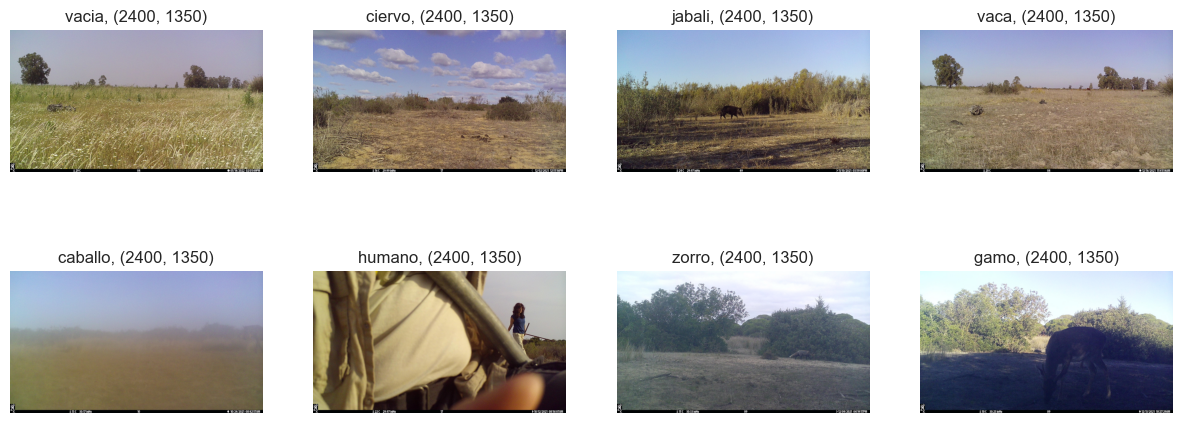

In [104]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

### Distribución de datos

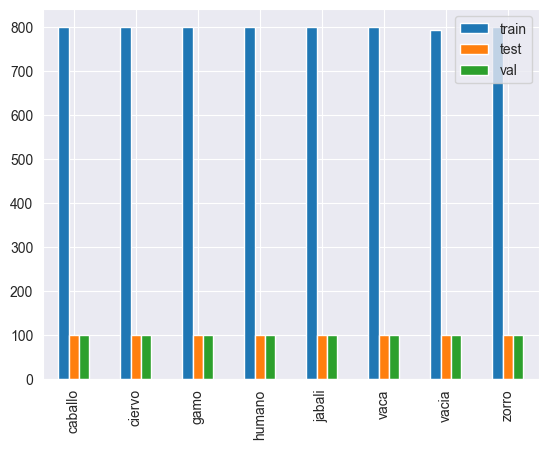

In [100]:
train_labels = df_train["class"]
test_labels = df_test["class"]
val_labels = df_val["class"]
# class_names = df_train["class"].unique()

class_names, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
_, val_counts = np.unique(val_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
                    'test': test_counts,
                    'val': val_counts},
             index=class_names
            ).plot.bar()
plt.show()

## Dataset

In [50]:
'''# Crear el directorio de SplitDataset si no existe
if not os.path.exists(split_path):
    os.makedirs(split_path)

# Función auxiliar para copiar las imágenes a las carpetas correspondientes
def copy_images_to_folders(csv_file, dest_dir):
    # Cargar el archivo CSV en un DataFrame de pandas
    df = pd.read_csv(csv_file)

    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        image_path = row['path']
        image_class = row['class']

        # Directorio de destino para la imagen según su clase
        class_dir = os.path.join(dest_dir, image_class)

        # Crear la carpeta de la clase si no existe
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Ruta completa de la imagen de origen y destino
        src_image = os.path.join(imgs_path, image_path)
        dest_image = os.path.join(class_dir, os.path.basename(image_path))

        # Copiar la imagen a la carpeta correspondiente
        shutil.copyfile(src_image, dest_image)

# Copiar las imágenes a las carpetas de train, val y test
copy_images_to_folders(train_csv_file, train_dir)
copy_images_to_folders(val_csv_file, val_dir)
copy_images_to_folders(test_csv_file, test_dir)'''

"# Crear el directorio de SplitDataset si no existe\nif not os.path.exists(split_path):\n    os.makedirs(split_path)\n\n# Función auxiliar para copiar las imágenes a las carpetas correspondientes\ndef copy_images_to_folders(csv_file, dest_dir):\n    # Cargar el archivo CSV en un DataFrame de pandas\n    df = pd.read_csv(csv_file)\n\n    # Iterar sobre cada fila del DataFrame\n    for index, row in df.iterrows():\n        image_path = row['path']\n        image_class = row['class']\n\n        # Directorio de destino para la imagen según su clase\n        class_dir = os.path.join(dest_dir, image_class)\n\n        # Crear la carpeta de la clase si no existe\n        if not os.path.exists(class_dir):\n            os.makedirs(class_dir)\n\n        # Ruta completa de la imagen de origen y destino\n        src_image = os.path.join(imgs_path, image_path)\n        dest_image = os.path.join(class_dir, os.path.basename(image_path))\n\n        # Copiar la imagen a la carpeta correspondiente\n     

In [51]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    # seed=SEED,
    #image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    #label_mode="categorical"
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle = False,
    # seed=SEED,
    #image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    #label_mode="categorical"
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle = False,
)


Loading Train Data...
Found 6391 files belonging to 8 classes.

Loading Validation Data...
Found 800 files belonging to 8 classes.

Loading Test Data...
Found 799 files belonging to 8 classes.


# Data Preprocessing

In [109]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Data Processing Stage with resizing and rescaling operations
data_preprocess_data_augmentation = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing

        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),

        tf.keras.layers.RandomContrast(0.2), # (x - mean) * contrast_factor + mean
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.GaussianNoise(0.1)
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess_data_augmentation(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess_data_augmentation(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

TypeError: in user code:

    File "C:\Users\albam\AppData\Local\Temp\ipykernel_6748\2649857950.py", line 28, in None  *
        lambda x, y: (data_preprocess_data_augmentation(x, traning=True), y)
    File "C:\Users\albam\.virtualenvs\tensorflow_cpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\albam\.virtualenvs\tensorflow_cpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
        return fn(*args, **kwargs)

    TypeError: Sequential.call() got an unexpected keyword argument 'traning'


### Data Augmentation

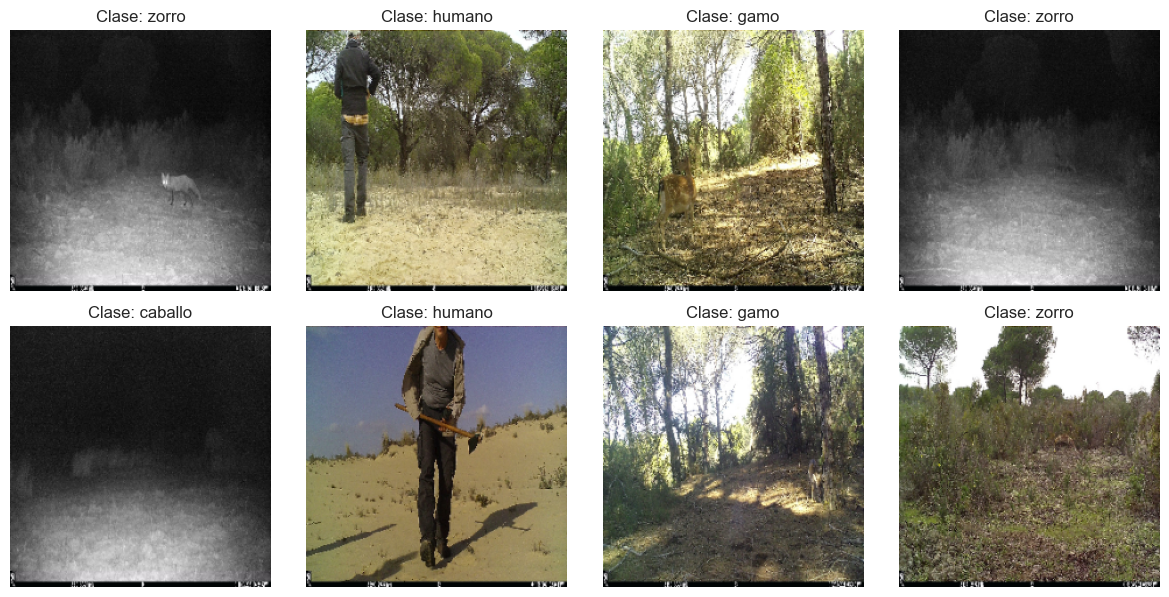

In [116]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes aumentadas y sus etiquetas del conjunto de entrenamiento
augmented_images = []
labels = []
for images, batch_labels in train_ds.take(1):
    augmented_images = images.numpy()[:8]
    labels = batch_labels.numpy()[:8]

# Obtener los nombres de las clases
class_names = train_data.class_names

# Visualizar las imágenes aumentadas con sus etiquetas
plt.figure(figsize=(12, 12))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Clase: {class_names[labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# MobileNet

### Modelo

In [60]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(
    weights=INITIAL_WEIGHTS,
    include_top=False,
    input_shape=TARGET_SHAPE)

# Capas del modelo
pretrained_mobilenet_model.trainable=False

# Añadir capas (entrenables)
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(
        NUM_CLASSES,
        activation='softmax')
])

In [61]:
mobilenet_model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

In [62]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


### Entrenamiento

In [64]:
history_mobilenet = mobilenet_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=CALLBACKS)
# buscar para guardar history en cada epoch

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.2255 - accuracy: 0.5744
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to ../../Models/MobileNetV2\best_model_20230625_2110_0.5250.h5
200/200 [==============================] - 132s 634ms/step - loss: 1.2255 - accuracy: 0.5744 - val_loss: 1.3214 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.7124
Epoch 2: val_accuracy did not improve from 0.52500
200/200 [==============================] - 111s 552ms/step - loss: 0.8610 - accuracy: 0.7124 - val_loss: 1.2902 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.7660 - accuracy: 0.7457
Epoch 3: val_accuracy improved from 0.52500 to 0.53500, saving model to ../../Models/MobileNetV2\best_model_20230625_2110_0.5350.h5
200/200 [==============================] - 104s 515ms/step - loss: 0.7660 - accuracy: 0.7457 - val_loss:

#### C

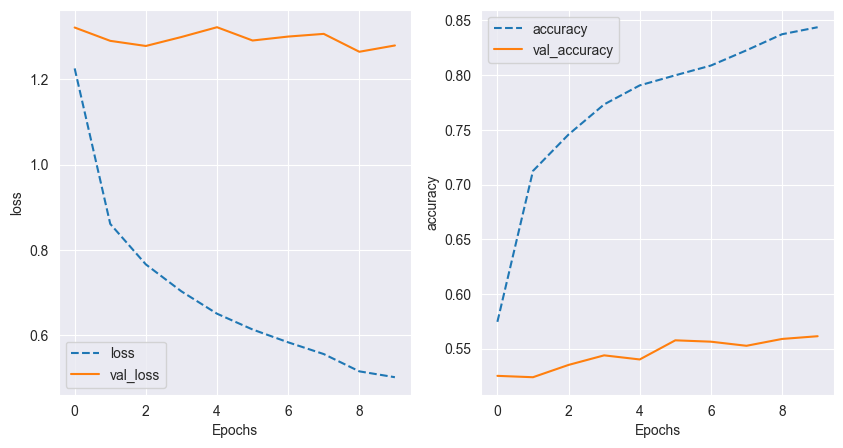

In [65]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [70]:
y_pred = mobilenet_model.predict(test_ds)

25/25 [==============================] - 12s 470ms/step


In [71]:
mobilenet_model.evaluate(test_ds)

25/25 [==============================] - 11s 398ms/step - loss: 0.9162 - accuracy: 0.6721


[0.9162049889564514, 0.6720901131629944]

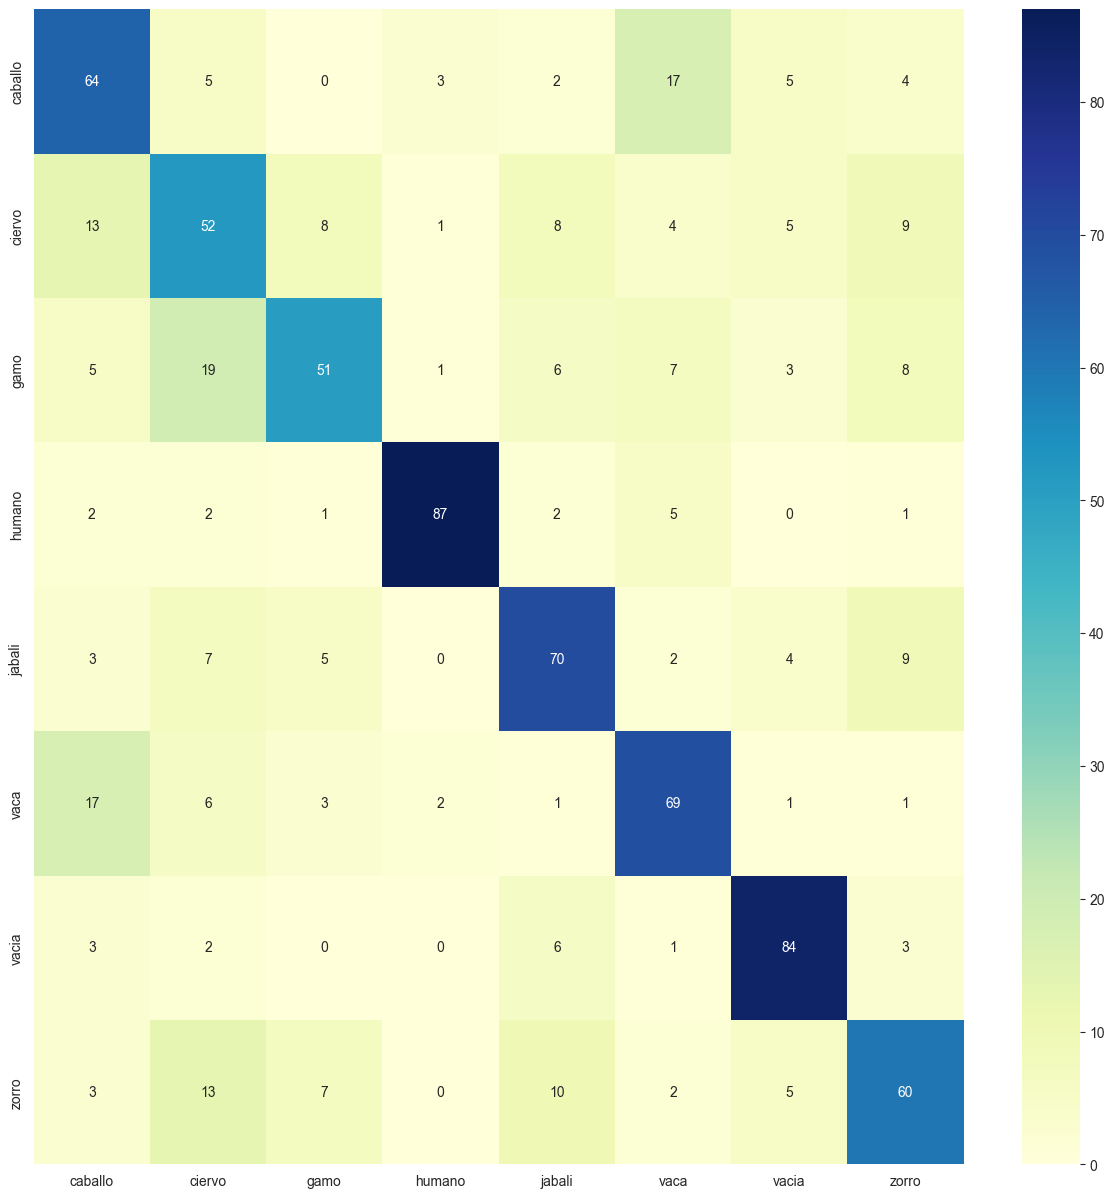

In [73]:
TestConfusionMatrix(y_pred, test_ds, test_data.class_names)
# pintar tambn para train y val

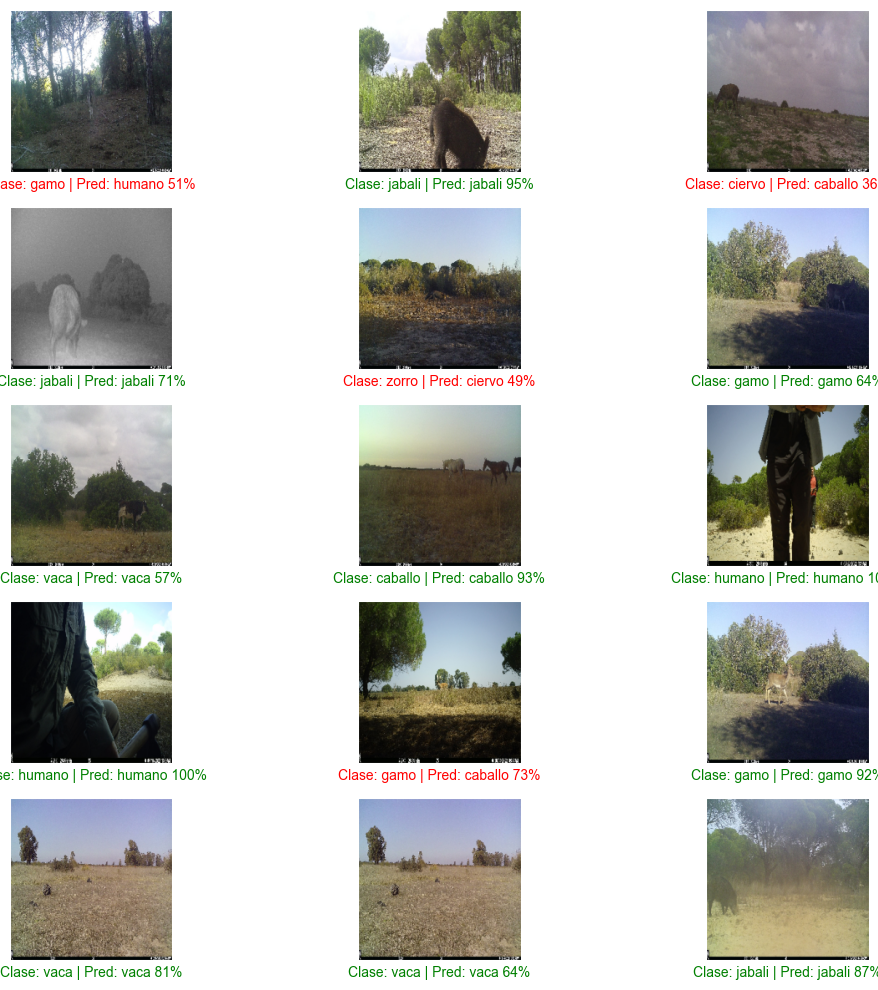

In [74]:
plot_predictions(y_pred)

### Siguientes pasos:

- Reentrenar la red (poner capas que no eran entrenables a entrenar y las ultimas capas ya entrenadas no entrenables.

### Posibles añadidos
- Gráfica con la probabilidad de que sea cada clase